# Projeto 8 
---
### Você se saiu muito bem no curso da TripleTen e recebeu uma oferta de estágio no departamento analítico da Y.Afisha. Sua primeira tarefa é ajudar a empresa a otimizar suas despesas com marketing.

Você tem:

* Logs do servidor com dados sobre os acessos a Y.Afisha de janeiro de 2017 até dezembro de 2018
* Arquivo de despejo (ou dump file, em inglês) com todos os pedidos feitos durante o período
* Estatísticas de despesas com marketing

Você vai analisar:

* Como as pessoas usam o produto
* Quando elas começam a comprar
* Quanto dinheiro cada cliente traz para a empresa
* Quando as despesas serão cobertas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 2.5})

#### Passo 1. Carregamento de dados e preparo para análise

In [2]:
orders = pd.read_csv('orders_log_us.csv')
logs = pd.read_csv('visits_log_us.csv')
costs = pd.read_csv('costs_us.csv')

In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [6]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [7]:
logs.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [8]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


* Nome de algumas colunas estão fora do formato snake case
* Algumas colunas precisam ter seus formato de dados corrigidos para possibilitar análise e para aumento de performance.
    * Buy ts, End ts, Start ts, dt: Object > Datetime 
    * Device: object > category  
* Nenhum data frame possui dados ausentes 

In [9]:
# columns to snake case

def new_col_names(df):
    new_names = []
    for old_name in df.columns:
        # remove os espaços no início e no final
        name_stripped = old_name.strip()
        # todas as letras em minúsculas
        name_lowered = name_stripped.lower()
        # substitui os espaços entre as palavras por sublinhados
        name_no_spaces = name_lowered.replace(' ', '_')
        # Adicionando a lista de novos nomes
        new_names.append(name_no_spaces)
    # Substitui os nomes antigos pelos novos
    df.columns = new_names
    return print(df.columns)

In [10]:
new_col_names(orders)
new_col_names(logs)
new_col_names(costs)

Index(['buy_ts', 'revenue', 'uid'], dtype='object')
Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')
Index(['source_id', 'dt', 'costs'], dtype='object')


In [11]:
# columns to right format
logs['device'].value_counts()

orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
logs['start_ts'] = pd.to_datetime(logs['start_ts'])
logs['end_ts'] = pd.to_datetime(logs['end_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])
logs['device'] = logs['device'].astype('category')

In [12]:
orders.describe()

,buy_ts,revenue,uid
count,50415,50415.000000,5.041500e+04
mean,2017-12-20 05:14:24.846176768,4.999647,9.098161e+18
min,2017-06-01 00:10:00,0.000000,3.135781e+14
25%,2017-10-13 17:28:00,1.220000,4.533567e+18
50%,2017-12-21 14:12:00,2.500000,9.102274e+18
75%,2018-03-02 16:10:00,4.890000,1.368290e+19
max,2018-06-01 00:02:00,2633.280000,1.844617e+19
std,NaN,21.818359,5.285742e+18


In [13]:
logs.describe()

,end_ts,source_id,start_ts,uid
count,359400,359400.000000,359400,3.594000e+05
mean,2017-12-18 06:28:15.036205056,3.750515,2017-12-18 06:17:32.010517760,9.202557e+18
min,2017-06-01 00:02:00,1.000000,2017-06-01 00:01:00,1.186350e+13
25%,2017-10-15 09:45:45,3.000000,2017-10-15 09:41:00,4.613407e+18
50%,2017-12-18 18:59:30,4.000000,2017-12-18 18:46:00,9.227413e+18
75%,2018-02-28 10:08:15,5.000000,2018-02-28 09:54:00,1.372824e+19
max,2018-06-01 01:26:00,10.000000,2018-05-31 23:59:00,1.844668e+19
std,NaN,1.917116,NaN,5.298433e+18


In [14]:
costs.describe()

,source_id,dt,costs
count,2542.000000,2542,2542.000000
mean,4.857199,2017-11-29 09:04:57.403619072,129.477427
min,1.000000,2017-06-01 00:00:00,0.540000
25%,2.000000,2017-08-30 00:00:00,21.945000
50%,4.000000,2017-11-29 00:00:00,77.295000
75%,9.000000,2018-02-28 00:00:00,170.065000
max,10.000000,2018-05-31 00:00:00,1788.280000
std,3.181581,NaN,156.296628


#### Passo 2. Relatórios e calculo de métricas:

##### Produtos 

Quantas pessoas usam-no cada dia, semana e mês? 

In [15]:
# user activity metrics

logs['session_year'] = logs['start_ts'].dt.year
logs['session_month'] = logs['start_ts'].dt.month
logs['session_week'] = logs['start_ts'].dt.isocalendar().week
logs['session_date'] = logs['start_ts'].dt.date

logs_desktop = logs[logs['device'] == 'desktop']
logs_touch = logs[logs['device'] == 'touch']


def user_activity(df):
    dau_total = df.groupby('session_date').agg({'uid': 'nunique'}).mean()
    wau_total = df.groupby('session_week').agg({'uid': 'nunique'}).mean()
    mau_total = df.groupby('session_month').agg({'uid': 'nunique'}).mean()
    print('daily activity:', int(dau_total))
    print('weekly activity:', int(wau_total))
    print('montly activity:', int(mau_total))
    return


print(f'Atividade de usuários para desktop:')
user_activity(logs_desktop)
print()
print(f'Atividade de usuários para touch:')
user_activity(logs_touch)

Atividade de usuários para desktop:
daily activity: 659
weekly activity: 4208
montly activity: 16724

Atividade de usuários para touch:
daily activity: 252
weekly activity: 1666
montly activity: 6825


Atividade em dispositivos movéis é menor do que em computadores

Quantas sessões ocorrem por dia? (um usuário pode realizar várias sessões).

In [16]:
# sessions per user daily
sessions_per_user = logs_desktop.groupby('session_date').agg(
    {'uid': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / \
    sessions_per_user['n_users']

print(f"Sessões em desktop por dia: {
      sessions_per_user['sessions_per_user'].mean()}")
print()

sessions_per_user = logs_touch.groupby('session_date').agg(
    {'uid': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / \
    sessions_per_user['n_users']

print(f"Sessões em mobile por dia: {
      sessions_per_user['sessions_per_user'].mean()}")

Sessões em desktop por dia: 1.0889553115247612

Sessões em mobile por dia: 1.0510715741665035


* Em média cada usuário tem 1 sessão por dia, independente do dispositivo usado

Qual duração tem cada sessão? (desktop e mobile)

In [17]:
# ASL: Average session length

logs_desktop['session_durantion_sec'] = (
    logs_desktop['end_ts'] - logs_desktop['start_ts']).dt.total_seconds()

print(f'Cada sessão em desktop tem duração média de: {
      logs_desktop['session_durantion_sec'].mean()}')
print()

logs_touch['session_durantion_sec'] = (
    logs_touch['end_ts'] - logs_touch['start_ts']).dt.total_seconds()

print(f'Cada sessão em mobile tem duração média de: {
      logs_touch['session_durantion_sec'].mean()}')

Cada sessão em desktop tem duração média de: 703.2888596053579

Cada sessão em mobile tem duração média de: 479.6194066072517


Duração média de cada sessão tem 591 segundos ou mais ou menos 10 minutos, parece ser bastante

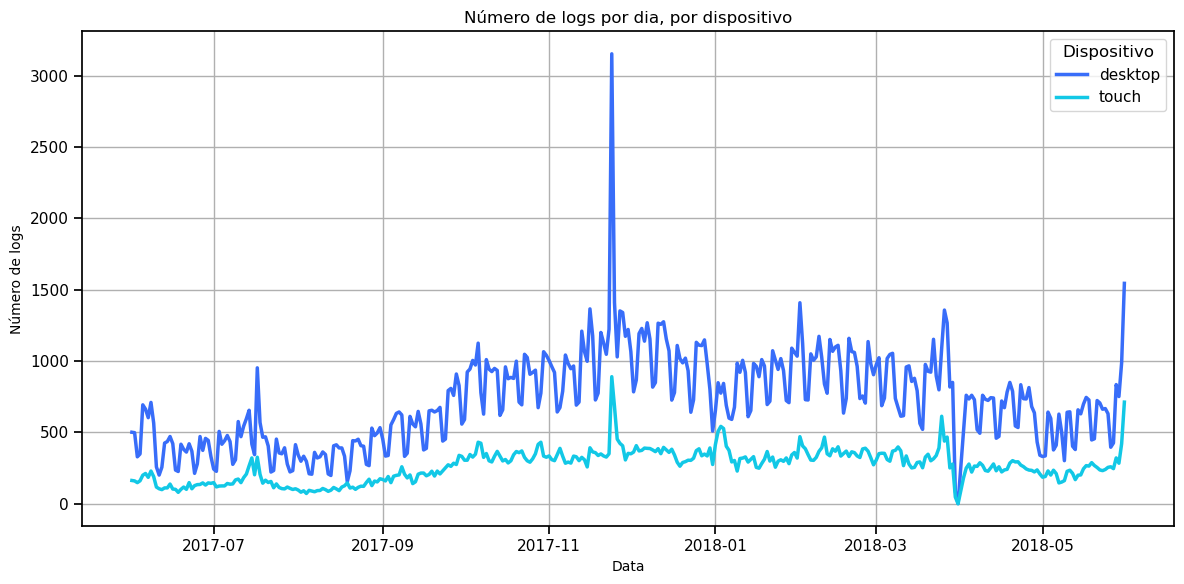

In [18]:
# plot distribution of logs by device
# count access by device and date
access_distribution = logs.groupby(
    ['device', 'session_date']).size().reset_index(name='access_count')


plt.figure(figsize=(12, 6))
sns.lineplot(data=access_distribution, x='session_date', y='access_count',
             hue='device')  # hue categoriza em grupo e cor diferente

# personalização
plt.title('Número de logs por dia, por dispositivo', fontsize=12)
plt.xlabel('Data', fontsize=10)
plt.ylabel('Número de logs', fontsize=10)
plt.legend(title='Dispositivo')
plt.grid(True)
plt.tight_layout()

plt.show()

Através do gráfico podemos ter certeza que o acesso através de desktop é maior do que touch

<Axes: >

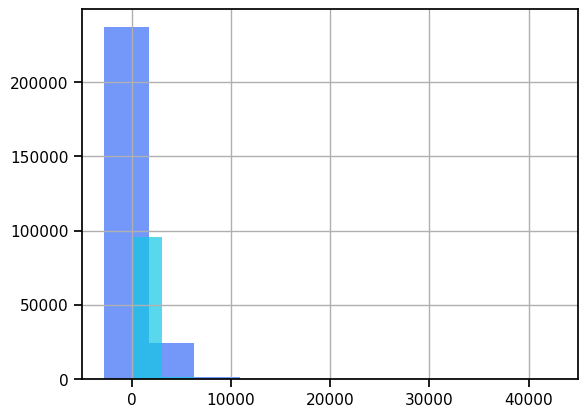

In [19]:
logs_desktop['session_durantion_sec'].hist(alpha=0.7)
logs_touch['session_durantion_sec'].hist(alpha=0.7)

Porém o gráfico acima mostra que não se trata de uma distribuição normal, alguns outliers estão distorcendo a distribuição, média ou mediana não seria o melhor método aqui. Talvez os outliers ocorreram por conta de usuários que esqueceram de encerrar suas sessões (log off) 

In [20]:
print(f'Sessão em desktop dura por volta de {
      logs_desktop['session_durantion_sec'].mode()} segundos')
print()
print(f'Sessão em mobile dura por volta de {
      logs_touch['session_durantion_sec'].mode()} segundos')

Sessão em desktop dura por volta de 0    60.0
Name: session_durantion_sec, dtype: float64 segundos

Sessão em mobile dura por volta de 0    60.0
Name: session_durantion_sec, dtype: float64 segundos


* Cada sessão dura mais ou menos 60 segundos independente do dispositivo

Com que frequência os usuários voltam?

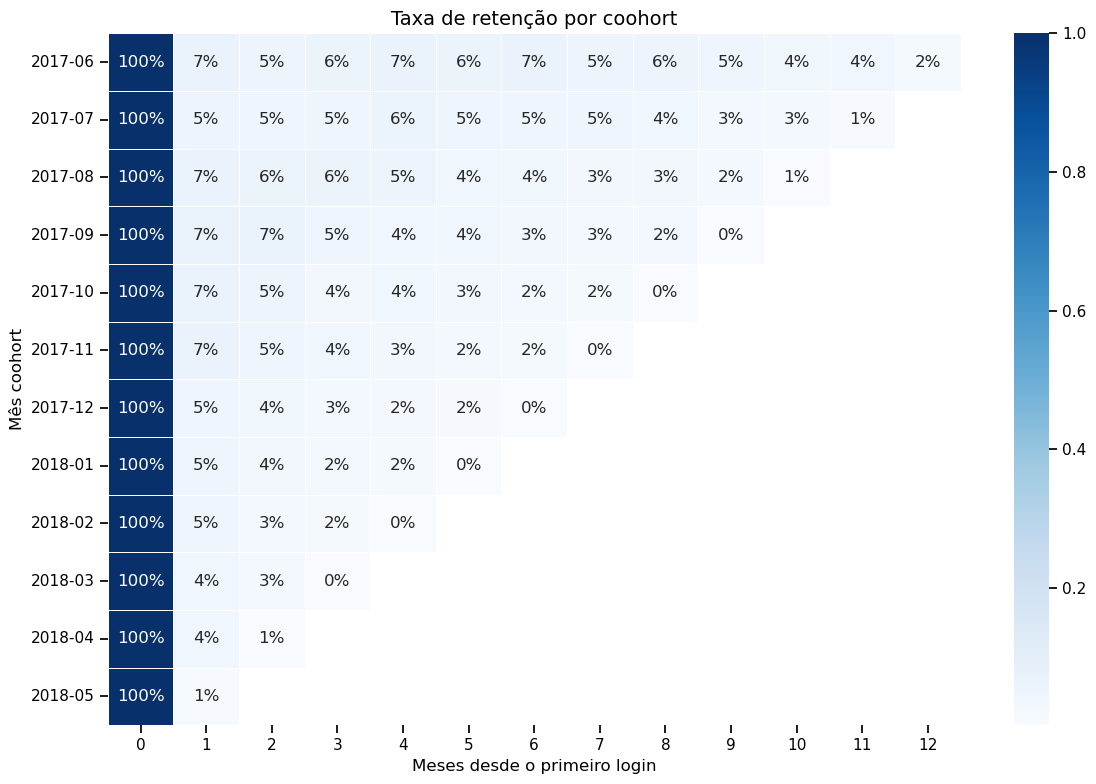

In [ ]:
# retention rate, how often do users come back?

# first access each user
first_session = logs.groupby('uid')['start_ts'].min()

# join first session to log
first_session.name = 'first_session'
logs = logs.join(first_session, on='uid')

# age cohort
logs['age'] = (logs['session_date'] - logs['first_session'].dt.date) / np.timedelta64(30, 'D')
logs['age'] = logs['age'].round().astype('int')

logs['first_log_month'] = logs['first_session'].dt.to_period('M')

# new df for cohort
retention_cohort = logs.groupby(['first_log_month', 'age']).agg({'uid': 'nunique'}).reset_index()

# filter to get initial user count and calculate retention rate
initial_users_count = retention_cohort[retention_cohort['age'] == 0][['first_log_month', 'uid']]

# rename to merge for cohort user
initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_inital_users'})
retention_cohort = retention_cohort.merge(initial_users_count, on='first_log_month')

# now ready to calculate retention rate!
retention_cohort['retention'] = retention_cohort['uid'] / retention_cohort['cohort_inital_users']

retention_pivot = retention_cohort.pivot_table(
    index='first_log_month',
    columns='age',
    values='retention',
    aggfunc='mean'
)

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(retention_pivot, annot=True, fmt=".0%",cmap="Blues", linewidths=0.5)

plt.title('Taxa de retenção por coohort', fontsize=14)
plt.xlabel('Meses desde o primeiro login', fontsize=12)
plt.ylabel('Mês coohort', fontsize=12)

plt.tight_layout()
plt.show()

Como podemos observar há uma taxa de retenção muito baixa, usuários praticamente não voltam a usar o serviço no segundos mês

##### Vendas

Quando as pessoas começam a comprar?

In [22]:
# When customers start to buy

orders = orders.join(first_session, on='uid')

# cohort life time em dias
orders['conversion_days'] = (
    orders['buy_ts'] - orders['first_session']).dt.days

# Convertion categories (example: 0d, 1-2d, 3-7d, 8-30d, >30d)
# flot('inf) representa "infinito", usado para capturar qualquer valor maior que 30.
bins = [0, 1, 3, 8, 31, float('inf')]
labels = ['0d', '1-2d', '3-7d', '8-30d', '>30d']

# right=False Faz com que o limite direito (]) não seja incluído no intervalo, ou seja, o intervalo [8,31], 31 não é incluido. entra na label 8-30
# include_lowest=True para incluir o 0 como categoria 0d
orders['conversion_category'] = pd.cut(
    orders['conversion_days'], bins=bins, labels=labels, right=False, include_lowest=True)

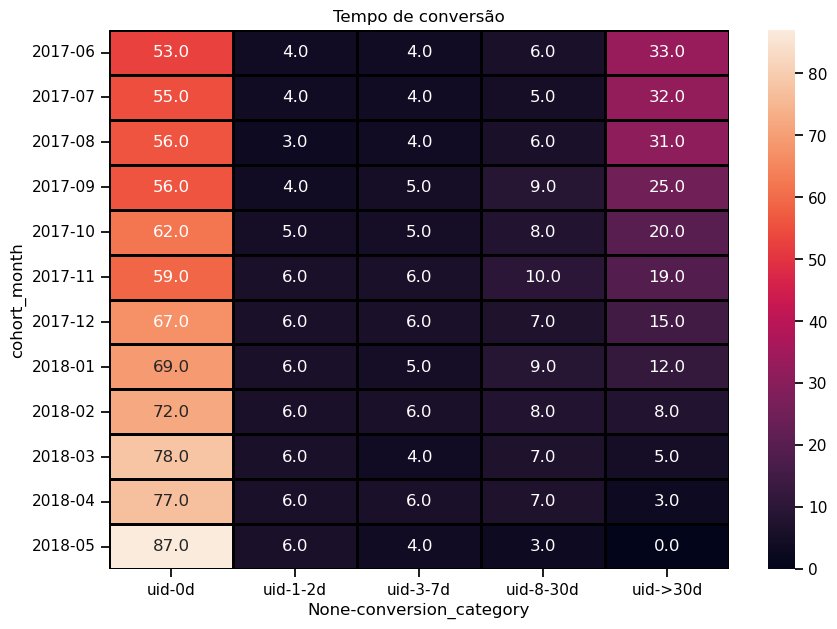

Média todos os coortes 0d: 66.0


In [23]:
# cohort granularity
orders['cohort_month'] = orders['first_session'].dt.to_period('M')

# Pivot a level of the (necessarily hierarchical) index labels.
cohort_analysis = orders.groupby(['cohort_month', 'conversion_category']).agg({
    'uid': 'nunique'}).unstack()

# Proportion of users by conversion_category
cohort_analysis_percentage = round(cohort_analysis.div(
    cohort_analysis.sum(axis=1), axis=0) * 100)

# heatmap
plt.figure(figsize=(10, 7))
plt.title('Tempo de conversão')
sns.heatmap(
    cohort_analysis_percentage,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='black'
)

plt.show()
print(f'Média todos os coortes 0d: {
      cohort_analysis_percentage['uid', '0d'].mean().round()}')

Como é observado no mapa de calor, a grande maioria dos clientes já fazem suas primeiras compras no mesmo dia de primeiro acesso. Sendo a média de todos os coortes para primeira compra no mesmo dia 66% 

Qual seria o canal de marketing mais eficiente?

In [24]:
# one user can log several times before buying the product, in this case:
# get first log in, drop duplicates to keep the first unique uid
logs_uid = logs.sort_values('start_ts').drop_duplicates(subset='uid')

Passo acima foi necessário para não duplicar a tabela orders com muitos logs

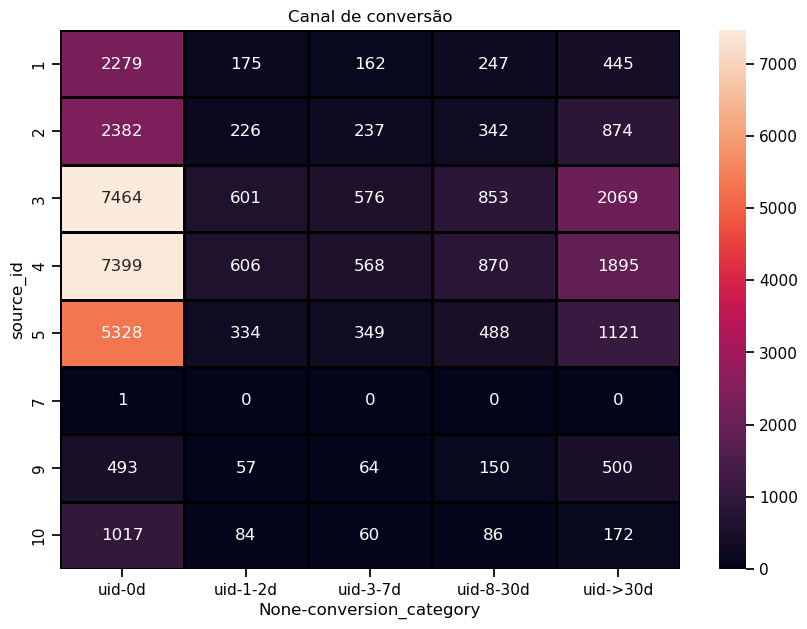

In [25]:
# Most efficient marketing chanel
# merge to get source_id
orders = pd.merge(orders, logs_uid[['uid', 'source_id']], on='uid', how='left')

# pivot chanel analysis
channel_analysis = orders.groupby(['source_id', 'conversion_category']).agg({
    'uid': 'nunique'}).unstack()

plt.figure(figsize=(10, 7))
plt.title('Canal de conversão')
sns.heatmap(
    channel_analysis,
    annot=True,
    fmt='.0f',
    linewidths=1,
    linecolor='black'
)

plt.show()

Canais de marketing com conversão mais rápida seriam os canais 3 e 4 

##### Quantos pedidos os clientes fazem durante um determinado período de tempo?

In [26]:
# how many orders per period
orders['period'] = orders['buy_ts'].dt.to_period('M')

purchases_grouped_by_cohorts = orders.groupby(['cohort_month', 'period']).agg(
    {'uid': ['count', 'nunique']})  # number of orders, and number of users
purchases_grouped_by_cohorts['purchases_by_user'] = (
    purchases_grouped_by_cohorts['uid', 'count'] / purchases_grouped_by_cohorts['uid', 'nunique']).round()

mean_purchases_pivot = purchases_grouped_by_cohorts.pivot_table(
    index='cohort_month',
    columns='period',
    values='purchases_by_user',
    aggfunc='mean'
)

mean_n_orders_per_cohort = mean_purchases_pivot.mean(axis=1)
print(mean_n_orders_per_cohort.mean())

1.2191798941798944


Em média um usuário fazem 1 a 2 compras no maximo dentro de um mês

Qual é o volume médio de uma compra?

In [27]:
# average revenue per order

total_revenue = orders['revenue'].sum()
total_orders = len(orders)  # number of orders
average_order_value = total_revenue/total_orders

print(f"Volume médio de uma compra: {average_order_value:.2f}")

Volume médio de uma compra: 5.00


Quanto dinheiro eles trazem para a empresa (LTV)?

In [28]:
# get first order and merge with orders
first_order = orders.groupby('uid')['buy_ts'].min().reset_index()
first_order.columns = ['uid', 'first_order']
orders_df = pd.merge(orders, first_order, on='uid')

# convert to correct date format and calculate age in months
orders['first_order'] = pd.to_datetime(orders_df['first_order']).dt.date
orders['first_order_month'] = pd.to_datetime(
    orders_df['first_order']).dt.to_period('M')
orders['buy_ts'] = pd.to_datetime(orders_df['buy_ts'])
orders['order_month'] = orders['buy_ts'].dt.to_period('M')
orders['age'] = (orders['order_month'].astype('int64') -
                 orders['first_order_month'].astype('int64'))

orders.head()

,buy_ts,revenue,uid,first_session,conversion_days,conversion_category,cohort_month,source_id,period,first_order,first_order_month,order_month,age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,0,0d,2017-06,1,2017-06,2017-06-01,2017-06,2017-06,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,0,0d,2017-06,2,2017-06,2017-06-01,2017-06,2017-06,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,0,0d,2017-06,2,2017-06,2017-06-01,2017-06,2017-06,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,0,0d,2017-06,2,2017-06,2017-06-01,2017-06,2017-06,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,0,0d,2017-06,3,2017-06,2017-06-01,2017-06,2017-06,0


In [29]:
# number of buyers by cohort
cohort_sizes = orders.groupby('first_order_month').agg(
    {'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06,2023
1,2017-07,1923
2,2017-08,1370
3,2017-09,2581
4,2017-10,4340
5,2017-11,4081
6,2017-12,4383
7,2018-01,3373
8,2018-02,3651
9,2018-03,3533


In [30]:
# groupby cohort and age to get revenue by cohort and age
cohorts = orders.groupby(['first_order_month', 'age'])[
    'revenue'].sum().reset_index()

# Merge and calculate ltv
report_ltv = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report_ltv['ltv'] = report_ltv['revenue'] / report_ltv['n_buyers']

report_ltv

,first_order_month,n_buyers,age,revenue,ltv
0,2017-06,2023,0,9557.49,4.724414
1,2017-06,2023,1,981.82,0.485329
2,2017-06,2023,2,885.34,0.437637
3,2017-06,2023,3,1931.30,0.954671
4,2017-06,2023,4,2068.58,1.022531
...,...,...,...,...,...
74,2018-03,3533,2,1114.87,0.315559
75,2018-04,2276,0,10600.69,4.657597
76,2018-04,2276,1,1209.92,0.531599
77,2018-05,2988,0,13925.76,4.660562


In [31]:
output = report_ltv.pivot_table(
    index='first_order_month',
    columns='age',
    values='ltv',
    aggfunc='mean'
)
ltv_cumsum = output.cumsum(axis=1).round(2)

In [32]:
ltv_cumsum

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


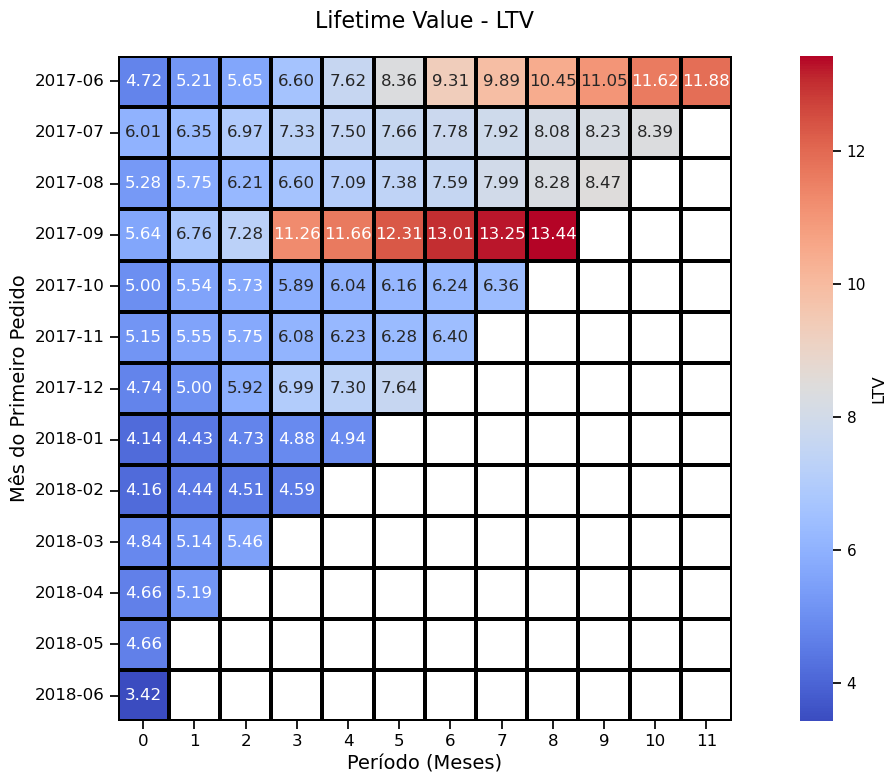

In [33]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    ltv_cumsum,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=1.5,
    linecolor='black',
    cbar_kws={'label': 'LTV'},
    square=True
)
plt.title("Lifetime Value - LTV", fontsize=16, pad=20)
plt.xlabel("Período (Meses)", fontsize=14)
plt.ylabel("Mês do Primeiro Pedido", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

##### Marketing

Quanto dinheiro foi gasto? No total/por origem/ao longo do tempo


O total gasto para o periodo de analise foi 329131.62



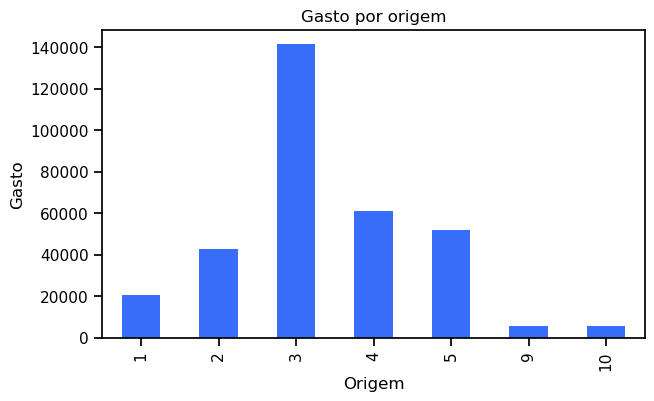

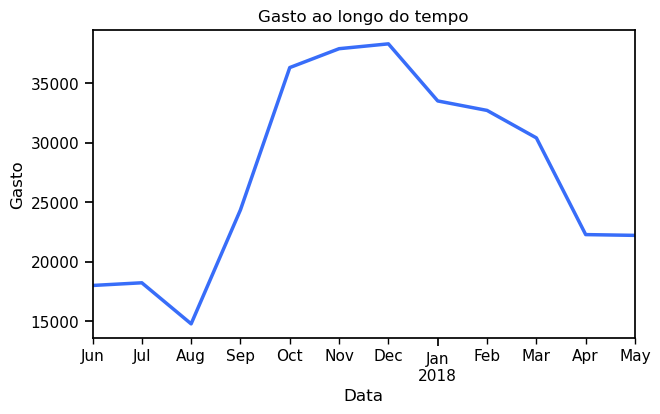

In [34]:
# How much did we spend?

# in total
total_cost = costs['costs'].sum()
print(f'O total gasto para o periodo de analise foi {total_cost}')
print()

# by source
cost_by_source = costs.groupby('source_id')['costs'].sum()

cost_by_source.plot(kind='bar', title='Gasto por origem', figsize=(7, 4))
plt.xlabel('Origem')
plt.ylabel('Gasto')
plt.show()

# by time
costs['month'] = costs['dt'].dt.to_period('M')
costs_ = costs.groupby('month')['costs'].sum()

costs_.plot(kind='line', title='Gasto ao longo do tempo', figsize=(7, 4))
plt.xlabel('Data')
plt.ylabel('Gasto')
plt.show()

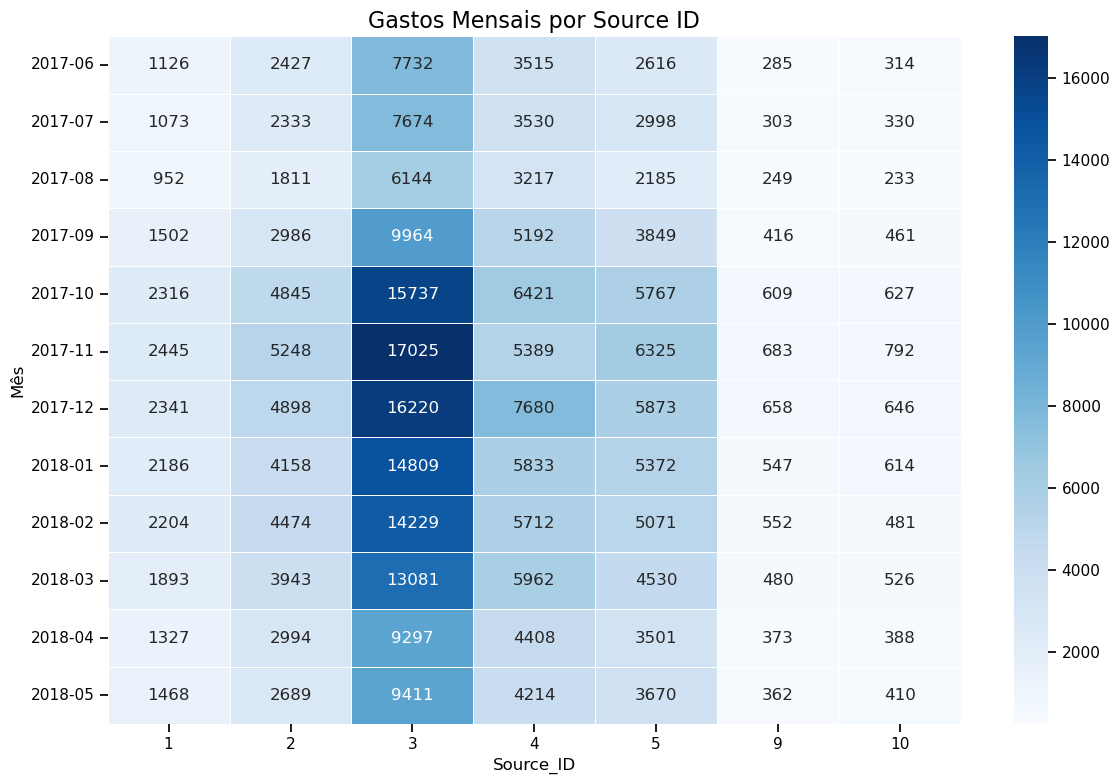

In [35]:
# groupby to heatmap
monthly_costs = costs.groupby(['month', 'source_id'])[
    'costs'].sum().unstack(fill_value=0)

# plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_costs, annot=True, fmt=".0f", cmap="Blues", linewidths=0.5)

plt.title('Gastos Mensais por Source ID', fontsize=16)
plt.xlabel('Source_ID', fontsize=12)
plt.ylabel('Mês', fontsize=12)

plt.tight_layout()
plt.show()

* Na análise de gastos, gastos em marketing na origem 3 se destaca dos demais. 
* Em gastos por mês os gastos com marketing sofreram um aumento exponencial entre setembro/outubro até dezembro, sofrendo ligeira queda entre janeiro e março mas ainda assim permanecendo alto, pelo heatmap vemos que o nesse mesmo periodo o canal 3 e 4 foram os responsaveis por esse aumento


Quanto custou a aquisição de clientes para cada origem?


In [36]:
# How much per customer by mkt source?

cost_by_source = cost_by_source.reset_index()

# number of customer by source
clients_per_source = orders.groupby(
    'source_id')['uid'].nunique().reset_index()
clients_per_source.rename(columns={'uid': 'n_buyers'}, inplace=True)

clients_per_source

,source_id,n_buyers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


Source_id 1, 2 e 7 contém números baixos de clientes, com número 7 contendo apenas 1 cliente

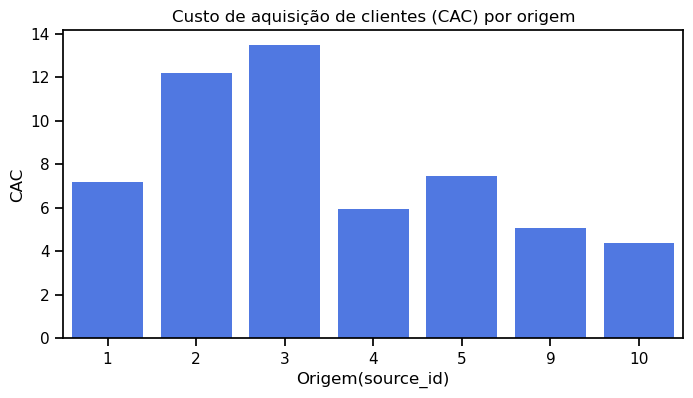

In [37]:
# merge by source_id
cac_by_source = pd.merge(cost_by_source, clients_per_source, on='source_id')

cac_by_source['cac'] = (cac_by_source['costs'] /
                        cac_by_source['n_buyers']).round(2)

# plot
plt.figure(figsize=(8, 4))
sns.barplot(data=cac_by_source, x='source_id', y='cac')
plt.title('Custo de aquisição de clientes (CAC) por origem')
plt.xlabel('Origem(source_id)')
plt.ylabel('CAC')
plt.show()

* A origem 2 e 3 é que a se destaca com custo de aquisição muito alto por cliente (12$ e 13$), porém na análise anterior de canais de marketing mais eficientes(velocidade conversão) o que se destacaram foram somente 3, 4 e 5. 

Os investimentos valeram a pena?
Analise geral

In [38]:
costs_ = costs.groupby('month')['costs'].sum().reset_index()
report = pd.merge(report_ltv, costs_,
                  left_on='first_order_month', right_on='month')

print(costs_.head())
print(report.head())

     month     costs
0  2017-06  18015.00
1  2017-07  18240.59
2  2017-08  14790.54
3  2017-09  24368.91
4  2017-10  36322.88
  first_order_month  n_buyers  age  revenue       ltv    month    costs
0           2017-06      2023    0  9557.49  4.724414  2017-06  18015.0
1           2017-06      2023    1   981.82  0.485329  2017-06  18015.0
2           2017-06      2023    2   885.34  0.437637  2017-06  18015.0
3           2017-06      2023    3  1931.30  0.954671  2017-06  18015.0
4           2017-06      2023    4  2068.58  1.022531  2017-06  18015.0


In [39]:
report['cac'] = report['costs']/report['n_buyers']

report.head()

,first_order_month,n_buyers,age,revenue,ltv,month,costs,cac
0,2017-06,2023,0,9557.49,4.724414,2017-06,18015.0,8.905091
1,2017-06,2023,1,981.82,0.485329,2017-06,18015.0,8.905091
2,2017-06,2023,2,885.34,0.437637,2017-06,18015.0,8.905091
3,2017-06,2023,3,1931.30,0.954671,2017-06,18015.0,8.905091
4,2017-06,2023,4,2068.58,1.022531,2017-06,18015.0,8.905091


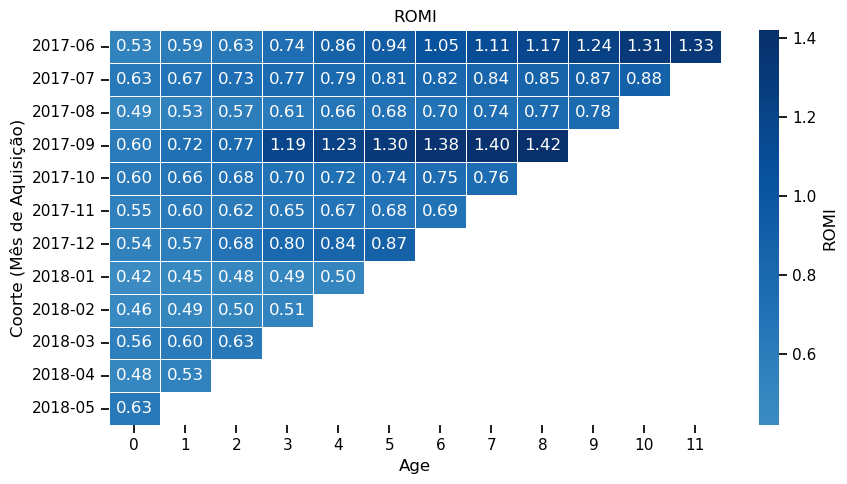

In [40]:
# ROMI geral
report['romi'] = report['ltv'] / report['cac']

output = report.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean'
)

output = output.cumsum(axis=1).round(2)

plt.figure(figsize=(9, 5))
sns.heatmap(output, annot=True, fmt=".2f", center=0, cbar_kws={'label': 'ROMI'}, linewidths=0.5,
            cmap="Blues")
plt.title(f'ROMI')
plt.xlabel('Age')
plt.ylabel("Coorte (Mês de Aquisição)")
plt.tight_layout()
plt.show()

In [41]:
print(output.mean(axis=0))

age
0     0.540833
1     0.582727
2     0.629000
3     0.717778
4     0.783750
5     0.860000
6     0.898333
7     0.970000
8     1.052500
9     0.963333
10    1.095000
11    1.330000
dtype: float64


* Aparentemente o retorno geral do investimento em marketing acontece somente a partir do oitavo mês, coortes de julho e setembro se destacam dos demais

Os investimentos valeram a pena?
Análise por source_id

In [42]:
# group to get revenue
revenue_per_source = orders.groupby(['first_order_month',
                                     'source_id', 'age'])['revenue'].sum().reset_index()

# group to get cost by source
cost_by_source = costs.groupby(['month', 'source_id'])[
    'costs'].sum().reset_index()

cost_by_source.rename(columns={'month': 'first_order_month'}, inplace=True)

# merge revenue and cost by source
roi_data = pd.merge(revenue_per_source, cost_by_source,
                    on=['first_order_month', 'source_id'])


roi_data.head()

,first_order_month,source_id,age,revenue,costs
0,2017-06,1,0,1378.70,1125.61
1,2017-06,1,1,414.98,1125.61
2,2017-06,1,2,419.43,1125.61
3,2017-06,1,3,714.24,1125.61
4,2017-06,1,4,811.20,1125.61


In [43]:
# n_buyers per cohort and source
cohort_sizes_ = orders.groupby(['first_order_month', 'source_id'])[
    'uid'].nunique().reset_index()

# merge n_buyers
roi_data = pd.merge(roi_data, cohort_sizes_, on=[
                    'first_order_month', 'source_id'])

roi_data.head()

,first_order_month,source_id,age,revenue,costs,uid
0,2017-06,1,0,1378.70,1125.61,190
1,2017-06,1,1,414.98,1125.61,190
2,2017-06,1,2,419.43,1125.61,190
3,2017-06,1,3,714.24,1125.61,190
4,2017-06,1,4,811.20,1125.61,190


In [44]:
roi_data['ltv'] = roi_data['revenue'] / roi_data['uid']
roi_data['cac'] = roi_data['costs']/roi_data['uid']

roi_data['roi'] = roi_data['ltv']/roi_data['cac']

roi_data.head()

,first_order_month,source_id,age,revenue,costs,uid,ltv,cac,roi
0,2017-06,1,0,1378.70,1125.61,190,7.256316,5.924263,1.224847
1,2017-06,1,1,414.98,1125.61,190,2.184105,5.924263,0.368671
2,2017-06,1,2,419.43,1125.61,190,2.207526,5.924263,0.372625
3,2017-06,1,3,714.24,1125.61,190,3.759158,5.924263,0.634536
4,2017-06,1,4,811.20,1125.61,190,4.269474,5.924263,0.720676


In [45]:
def roi_per_source(roi_data, source):
    roi_data_filtered = roi_data[roi_data['source_id'] == source]

    # Pivot for heatmap per source_id (criar função)
    heatmap_data = roi_data_filtered.pivot_table(
        values='roi', index='first_order_month', columns='age', aggfunc='mean')

    # Criar o heatmap
    plt.figure(figsize=(7, 4))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", center=0, cbar_kws={'label': 'ROI'}, linewidths=0.5,
                cmap="Blues")
    plt.title(f'Roi origem:{source}')
    plt.xlabel('Age')
    plt.ylabel("Coorte (Mês de Aquisição)")
    plt.tight_layout()
    plt.show()

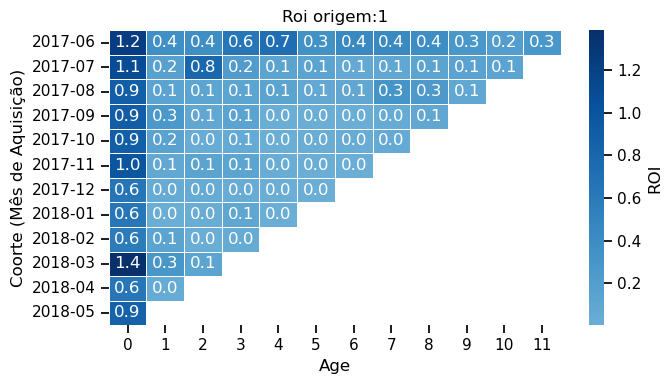

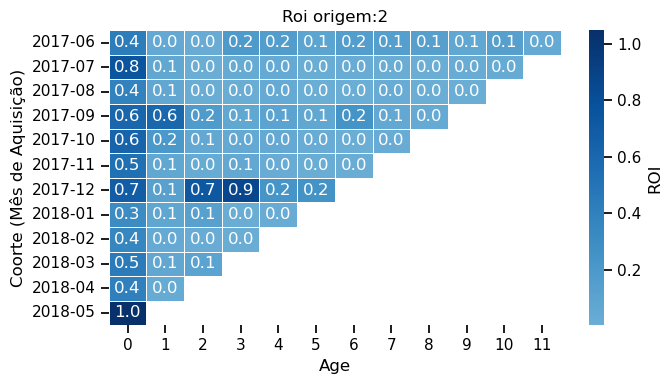

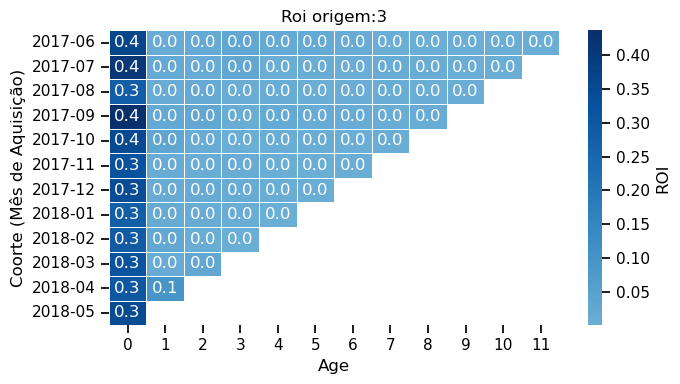

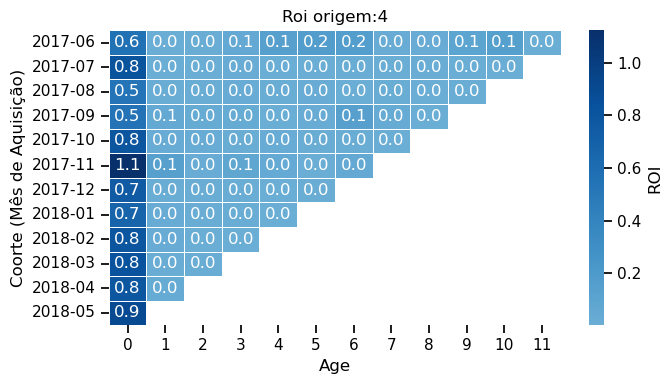

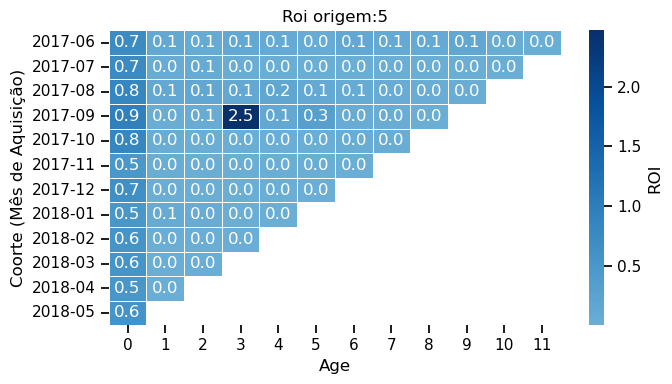

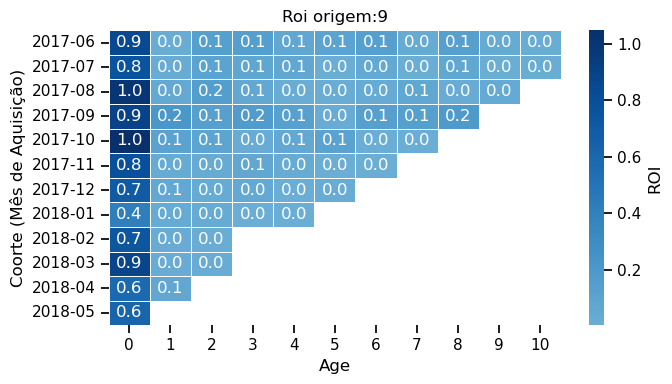

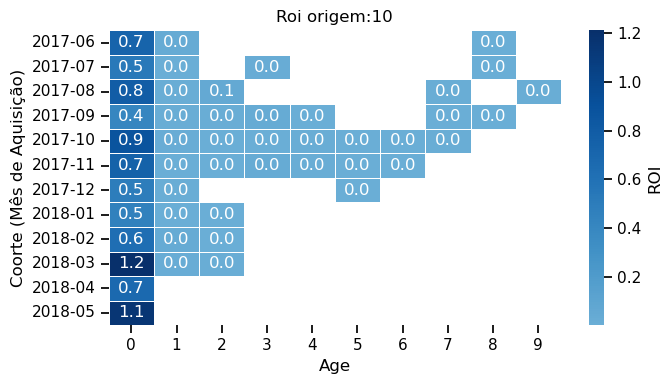

In [46]:
roi_per_source(roi_data, 1)
roi_per_source(roi_data, 2)
roi_per_source(roi_data, 3)
roi_per_source(roi_data, 4)
roi_per_source(roi_data, 5)
roi_per_source(roi_data, 9)
roi_per_source(roi_data, 10)

Canais de marketing 1, 2, 9 parecem ser os canais com maiores retornos em comparação com o valor investido (ROI), mas não parece ser algo duradouro, esse retorno só parece ser significativo no primeiro mês.

#### Passo 3. Conclusão

* Atividade em dispositivos movéis menor do que em computadores e emm média cada usuário tem 1 sessão por dia, independente do dispositivo usado, cada sessão dura mais ou menos 60 segundos independente do dispositivo, A taxa de retenção está muito baixa, usuários praticamente não voltam a usar o serviço no segundos mês

* A grande maioria dos clientes já fazem suas primeiras compras no mesmo dia de primeiro acesso. e os canais de marketing com conversão mais rápida seriam os canais 3 e 4 

* Em média um usuário faz 1 a 2 compras no máximo dentro de 1 mês e valor médio de uma um compra é 5$

* A origem 2 e 3 é que a se destaca com custo de aquisição muito alto por cliente (12$ e 13$), porém na análise anterior de canais de marketing mais eficientes(velocidade conversão) o que se destacaram foram somente 3, 4 e 5. 

* Em gastos por mês os gastos com marketing sofreram um aumento exponencial entre setembro/outubro até dezembro, sofrendo ligeira queda entre janeiro e março mas ainda assim permanecendo alto, pelo heatmap vemos que o nesse mesmo periodo o canal 3 foi o maior responsavel e 4 acompanhando ligeiramente

* Aparentemente o retorno geral do investimento em marketing acontece somente a partir do oitavo mês, coortes de julho e setembro se destacam dos demais

* Um marketing eficiente não é apenas gastar menos, mas gerar mais retorno a partir de cada unidade de custo. Com essa base ROI e CAC juntos fornecem uma visão sobre eficiência e rentabilidade, enquanto LTV garante que os clientes atraídos são valiosos no longo prazo.

* Com base na análise realizada, recomendaria priorizar investimentos nos canais 1, 4, 5 e 9, especialmente no canal 1 e 9 que apresentam bom ROI e baixo CAC, além de atrair clientes com alto LTV. Essas origens/campanhas foram eficientes em atrair clientes de alto valor, demonstraram eficiência e escalabilidade, gerando maior retorno sobre o capital investido. Por outro lado, canais como o canal 2 e 3, com altissimo CAC e ROI não significativo, indicam que talvez não sejam boas opções ou precisem de otimização (por exemplo, foco em públicos específicos ou ajuste de segmentação).
Certas origens com baixo custo total, mas alto ROI, caso do canal 1 e 9 podem representar oportunidades para aumentar investimentos (exemplo: parcerias com influenciadores ou afiliados). Canais como o canal 7 que só atraiu 1 cliente desde então devem ser revistas ou descontinuadas, pois não geram retorno suficiente para justificar os custos. Concentrei-me nas métricas ROI, CAC, LTV e Volume de clientes pois elas medem diretamente a rentabilidade e eficiência dos investimentos em marketing. Ao otimizar investimentos e testar novas estratégias nos canais de melhor desempenho, espera-se maximizar o impacto do orçamento em campanhas futuras.

* Também recomendaria uma concentração um pouco maior em device touch com uma melhor distribuição de investimentos e não a concentração em só apenas um canal como foi o caso do canal 3.

* Também é recomendável trabalhar em projetos/campanhas para melhorar a taxa de retenção que está baixissima, praticamente os clientes só usam o produto no primeiro mês. Recomendo investigação da causa raiz desse problema
